In [1]:
import numpy
import json

In [2]:
def make_dict(sentences : list, word_dict : dict = None) :
    data = " ".join(sentences).lower().replace("."," .").split()
    if word_dict is None :
        word_dict = {}
        word_dict["<eos>"] = 0
        word_dict["<unk>"] = 1
    for w in data :
        if w not in word_dict :
            word_dict[w] = len(word_dict)
    number_dict = {i : w for w, i in word_dict.items()}
    return word_dict, number_dict

def word_num_encoding(sentences : list, word_dict : dict, unk : str = "<unk>") :
    word_size = len(word_dict)
    corpus = []
    max_len = 0
    for s in sentences :
        s = s.lower().replace("."," .").split()
        max_len = max(max_len, len(s))
    for s in sentences :
        s_array = []
        s = s.lower().replace("."," .").split()
        for i in range(max_len) :
            if len(s) <= i :
                s_array.append(-1)
                continue
            try :
                s_array.append(word_dict[s[i]])
            except :
                s_array.append(word_dict[unk])
        corpus.append(s_array)
    corpus = numpy.array(corpus)    
    return corpus

def make_comatrix(corpus, word_size, window_size = 1) :
    comatrix = numpy.zeros(shape = (word_size, word_size))
    for s in corpus :
        for w in range(len(s)) :
            if s[w] < 0 :
                break
            for i in range(1,window_size+1) :
                if w-i >= 0 :
                    if s[w-i] >= 0 :
                        comatrix[s[w], s[w-i]] += 1
                if w+i < len(s) :
                    if s[w+i] >= 0  :
                        comatrix[s[w], s[w+i]] += 1
    return comatrix

def cos_similarity(x, y) :
    eps = 1e-15
    return numpy.dot(x,y) / (numpy.linalg.norm(x)*numpy.linalg.norm(y) + eps)

def most_similiar(query, word_dict, number_dict, comatrix, top = 5) :
    if query not in word_dict :
        print("{}(이)가 사전에 존재하지 않습니다.".format(query))
        return

    word_size = len(word_dict)
    similiar = numpy.zeros(shape = (word_size))
    for i in range(word_size) :
        similiar[i] = cos_similarity(comatrix[word_dict[query]], comatrix[i])

    print("검색어 ||",query)
    cnt = 0
    for i in (-1 * similiar).argsort() :
        if number_dict[i] == query :
            continue
        print("{} : {}".format(number_dict[i], similiar[i]))
        cnt += 1
        if cnt >= top :
            break
    print("")

def make_pmi(comatrix, verdose = False) :
    P = numpy.zeros_like(comatrix)
    N = numpy.sum(comatrix)
    S = numpy.sum(comatrix, axis = 0)
    eps = 1e-15
    
    cnt = 0
    total = P.shape[0] * P.shape[1]
    
    for i in range(P.shape[0]) :
        for j in range(P.shape[1]) :
            pmi = numpy.log2(comatrix[i, j] * N / (S[i]*S[j] + eps) + eps)
            P[i,j] = max(0, pmi)

            if verdose :
                cnt += 1
                if j+1 == P.shape[1] :
                    print("%.1f%% 완료" %(100*cnt/total))
    print("!!계산 완료!!")
    
    return P    

In [3]:
sentences = ["You say goodbye and I say hello.", "I and You."]

word_dict, number_dict = make_dict(sentences)
corpus = word_num_encoding(sentences, word_dict)

print(word_dict)
print(number_dict)
print(corpus)


{'<eos>': 0, '<unk>': 1, 'you': 2, 'say': 3, 'goodbye': 4, 'and': 5, 'i': 6, 'hello': 7, '.': 8}
{0: '<eos>', 1: '<unk>', 2: 'you', 3: 'say', 4: 'goodbye', 5: 'and', 6: 'i', 7: 'hello', 8: '.'}
[[ 2  3  4  5  6  3  7  8]
 [ 6  5  2  8 -1 -1 -1 -1]]


In [4]:
comatrix = make_comatrix(corpus, len(word_dict), 1)
print(comatrix)


[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 2. 0. 0.]
 [0. 0. 0. 1. 0. 2. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]]


In [5]:
#좌표간 유사도 비교법 : 코사인 유사도
similarity = cos_similarity(comatrix[word_dict["i"]],comatrix[word_dict["you"]])
print(similarity)

0.7745966692414832


In [13]:
most_similiar("you",word_dict, number_dict, comatrix,5)

검색어 || you
goodbye : 0.8164965809277257
hello : 0.8164965809277257
i : 0.7745966692414832
<eos> : 0.0
<unk> : 0.0


In [14]:
pmi = make_pmi(comatrix) 
print(pmi)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.73696559 0.         0.73696559
  0.         0.         1.73696559]
 [0.         0.         0.73696559 0.         1.32192809 0.
  0.73696559 1.32192809 0.        ]
 [0.         0.         0.         1.32192809 0.         1.32192809
  0.         0.         0.        ]
 [0.         0.         0.73696559 0.         1.32192809 0.
  1.73696559 0.         0.        ]
 [0.         0.         0.         0.73696559 0.         1.73696559
  0.         0.         0.        ]
 [0.         0.         0.         1.32192809 0.         0.
  0.         0.         2.32192809]
 [0.         0.         1.73696559 0.         0.         0.
  0.         2.32192809 0.        ]]


In [15]:
U, S, V = numpy.linalg.svd(pmi)
print(U[2,:2])

[5.52622691e-01 4.44089210e-16]


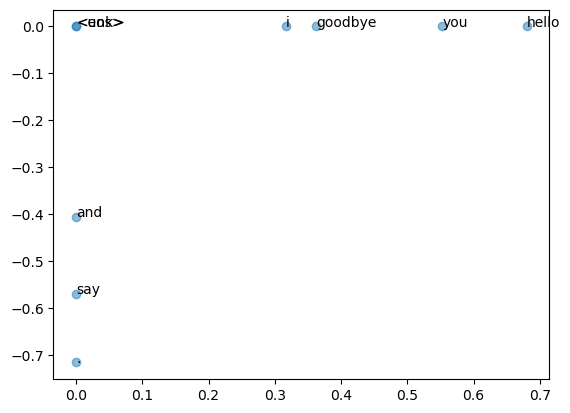

In [16]:
import matplotlib.pyplot as plt

flg, ax = plt.subplots()
for w, i in word_dict.items() :
    ax.annotate(w, (U[i,0], U[i,1]))
ax.scatter(U[:,0], U[:,1], alpha = 0.5)
plt.show()